# Training Full 3D UNet with Dice Loss and Ranger - Model 2

This notebook contains the code that I used to train a 3D U-Net model from scratch using the Dice Loss function and the Ranger optimizer.

## Installing and Importing Libraries

In [ ]:
!pip install segmentation_models==1.0.1 # I deleted the output of this cell since it is irrelevant.
!pip install nilearn
!pip install tensorflow-addons

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from losses import dice_coefficient
import segmentation_models as sm

import tensorflow as tf
from tensorflow import keras as K

import nibabel as nib
import numpy as np
import os
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading and Pre-processing the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!tar -xvf "/content/drive/MyDrive/Task01_BrainTumour.tar" -C "/content/" 

In [9]:
from util_intel import DatasetGenerator, z_normalize_img, crop, read_nifti_file, augment_data, unet_3d
data_path="/content/Task01_BrainTumour/"
bz_train=8
bz_val=4
bz_test=1
num_epochs=35
brats_datafiles = DatasetGenerator(data_path)

crop_dim = (128,128,128,1)
number_output_classes = 3

filters=8
saved_model_name = "3d_unet_decathlon"

seed=816

In [10]:
brats_datafiles = DatasetGenerator(data_path)
brats_datafiles.print_info()

Dataset name:         BRATS
Dataset description:  Gliomas segmentation tumour and oedema in on brain images
Tensor image size:    4D
Dataset release:      2.0 04/05/2018
Dataset reference:    https://www.med.upenn.edu/sbia/brats2017.html
Input channels:       {'0': 'FLAIR', '1': 'T1w', '2': 't1gd', '3': 'T2w'}
Output labels:        {'0': 'background', '1': 'edema', '2': 'non-enhancing tumor', '3': 'enhancing tumour'}
Dataset license:      CC-BY-SA 4.0


In [11]:
numFiles = brats_datafiles.numFiles
numTrain = 320
numValid=80
numTest=84

ds = tf.data.Dataset.range(numFiles).shuffle(numFiles, seed) # Shuffle the dataset

ds_train = ds.take(numTrain)
ds_val_test = ds.skip(numTrain)
ds_val = ds_val_test.take(numValid)
ds_test = ds_val_test.skip(numTest)

ds_train = ds_train.map(lambda x: tf.py_function(read_nifti_file, [x, crop_dim, True], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.map(lambda x: tf.py_function(read_nifti_file, [x, crop_dim, False], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(lambda x: tf.py_function(read_nifti_file, [x, crop_dim, False], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds_train = ds_train.batch(bz_train)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_val = ds_val.batch(bz_val)
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.batch(bz_test)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## Training the Models

Now, I can finally start training the model. I will train three models using the Soft Dice Loss with 0.001 - 0.00001, 0.0001 - 0.000001, and 0.00001 - 0.0000001 learning rate ranges.

### Model 1 : initial_lr = 0.001 and final_lr = 0.00001

In [14]:
initial_learning_rate =0.001
final_learning_rate=0.00001

radam = tfa.optimizers.RectifiedAdam(learning_rate=initial_learning_rate,min_lr=final_learning_rate)
optim = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)

In [ ]:
model_focal1 = unet_3d(fms=filters, input_dim=crop_dim)

model_focal1.compile(loss=soft_dice_loss, metrics=[tf.keras.metrics.BinaryAccuracy(), dice_coefficient, sm.metrics.IOUScore(threshold=0.5)], optimizer=optim)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint1 = ModelCheckpoint(
   'fullmodel2_dice_ranger1.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history1=model_focal1.fit(ds_train, epochs=num_epochs, validation_data=ds_val,callbacks=[checkpoint1])

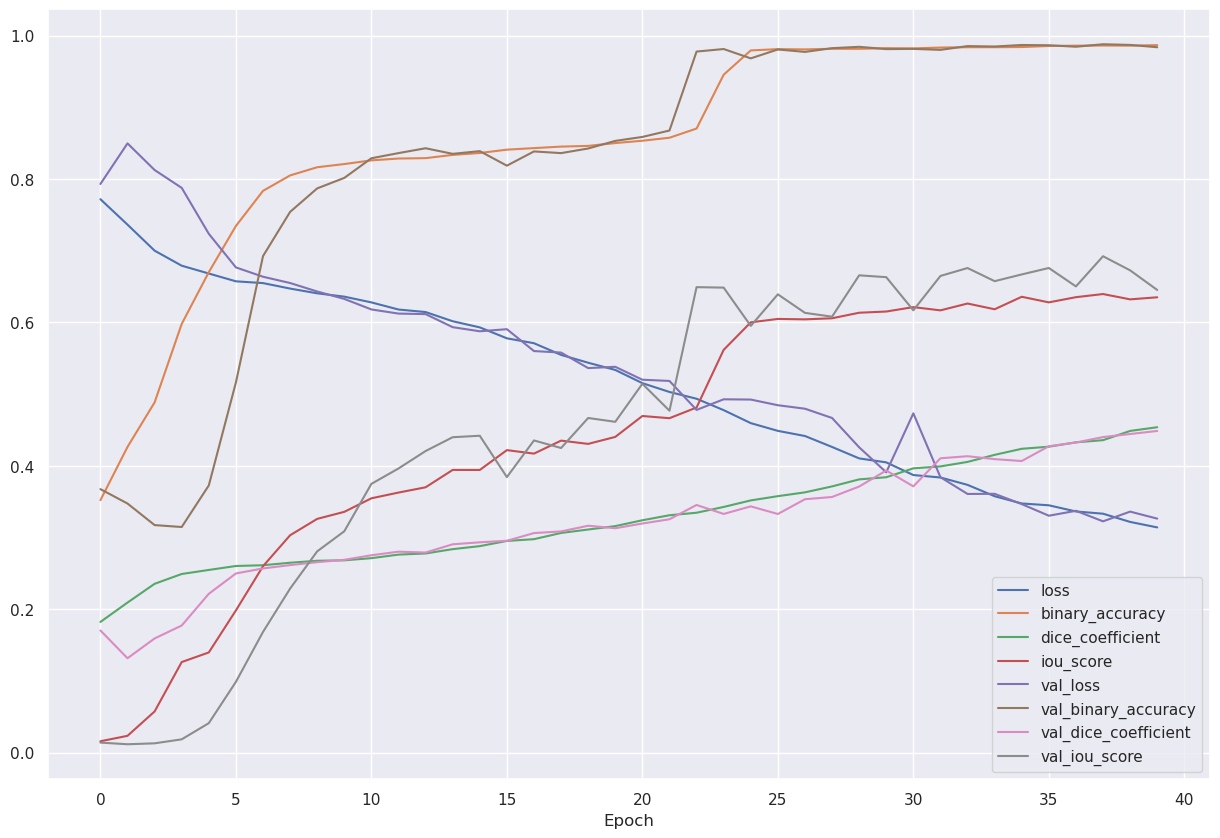

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
pd.DataFrame(history1.history).plot(figsize=(15, 10))
plt.xlabel("Epoch")
plt.legend(loc="best")
plt.show()

In [18]:
!cp -r '/content/fullmodel2_dice_ranger1.h5' /content/drive/MyDrive/ # let's save the weights first

### Model 2 : initial_lr = 0.0001 and final_lr = 0.000001

In [19]:
initial_learning_rate =0.0001
final_learning_rate=0.000001

radam = tfa.optimizers.RectifiedAdam(learning_rate=initial_learning_rate,min_lr=final_learning_rate)
optim = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)

In [ ]:
model_focal2 = unet_3d(fms=filters, input_dim=crop_dim)
model_focal2.compile(loss=soft_dice_loss, metrics=[tf.keras.metrics.BinaryAccuracy(), dice_coefficient, sm.metrics.IOUScore(threshold=0.5)], optimizer=optim)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint2 = ModelCheckpoint(
   'fullmodel2_dice_ranger2.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history2=model_focal2.fit(ds_train, epochs=40, validation_data=ds_val,callbacks=[checkpoint2])

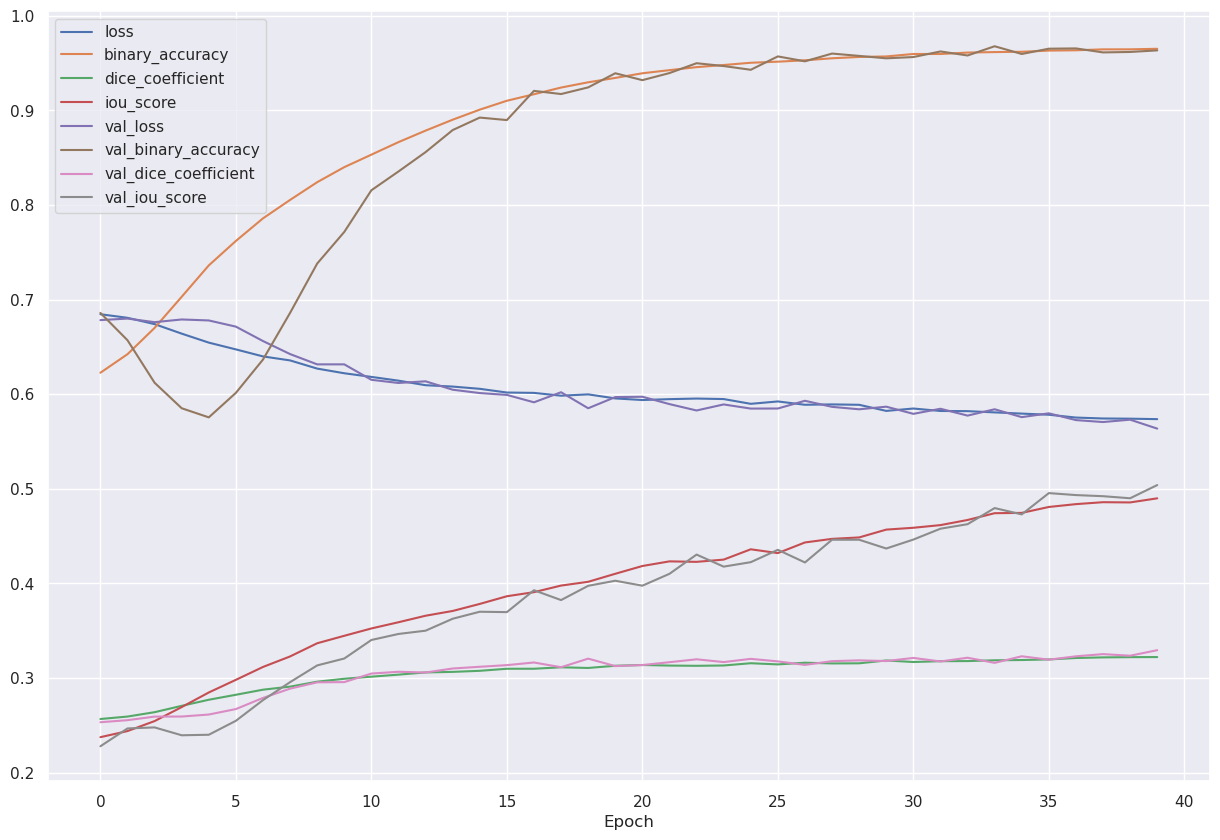

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
pd.DataFrame(history2.history).plot(figsize=(15, 10))
plt.xlabel("Epoch")
plt.legend(loc="best")
plt.show()

In [23]:
!cp -r '/content/fullmodel2_dice_ranger2.h5' /content/drive/MyDrive/ # let's save the weights first

### Model 3: initial_lr = 0.00001 and final_lr = 0.0000001

In [14]:
initial_learning_rate =0.00001
final_learning_rate=0.0000001

radam = tfa.optimizers.RectifiedAdam(learning_rate=initial_learning_rate,min_lr=final_learning_rate)
optim = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)

In [ ]:
model_focal3 = unet_3d(fms=filters, input_dim=crop_dim)
model_focal3.compile(loss=soft_dice_loss, metrics=[tf.keras.metrics.BinaryAccuracy(), dice_coefficient, sm.metrics.IOUScore(threshold=0.5)], optimizer=optim)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint3 = ModelCheckpoint(
   'fullmodel2_dice_ranger3.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history3=model_focal3.fit(ds_train, epochs=40, validation_data=ds_val,callbacks=[checkpoint3])

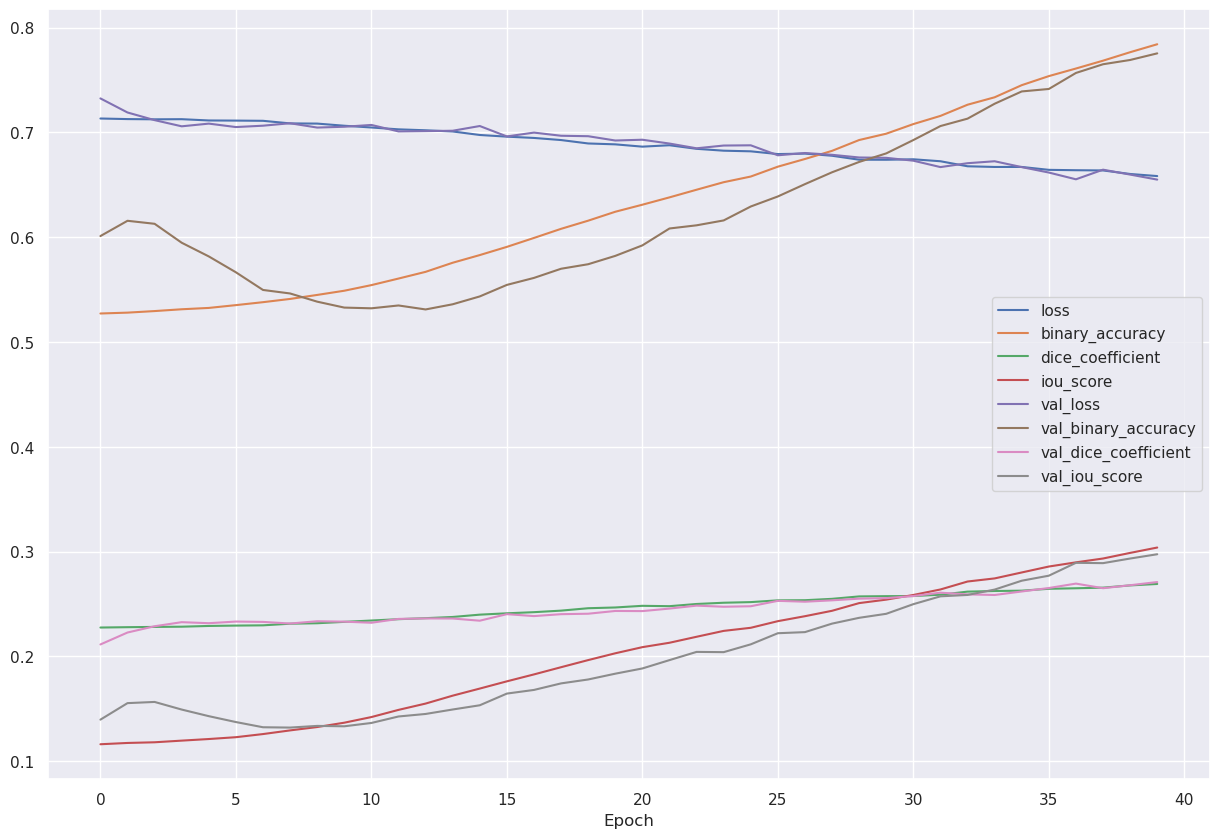

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
pd.DataFrame(history3.history).plot(figsize=(15, 10))
plt.xlabel("Epoch")
plt.legend(loc="best")
plt.show()

In [ ]:
!cp -r '/content/fullmodel2_dice_ranger3.h5' /content/drive/MyDrive/ # let's save the weights first